In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import torch
import sys
import os
import csv
import cv2
import time

from scipy.ndimage import binary_fill_holes
from scipy.ndimage import label, sum as ndimage_sum
from scipy.ndimage import distance_transform_edt
from scipy.ndimage import binary_dilation

from skimage.feature import peak_local_max
from segment_anything import sam_model_registry, SamPredictor
sys.path.append("..")

In [2]:
# Functions
DEBUG = True

def find_black_area(image, window_size):
    h, w = image.shape
    max_density = -1
    best_coords = (0, 0)

    # Slide the window over the image
    for y in range(0, h - window_size[1] + 1, 1):
        for x in range(0, w - window_size[0] + 1, 1):
            # Extract the window from the image
            window = image[y:y + window_size[1], x:x + window_size[0]]

            # Count the number of black pixels (assuming black pixels are 0)
            black_pixel_count = np.sum(window == 0)

            # Track the window with the maximum number of black pixels
            if black_pixel_count > max_density:
                max_density = black_pixel_count
                best_coords = (x, y)

    return best_coords


def find_lowest_and_right_points(contour):
    # Convert contour to a 2D array
    contour_points = contour[:, 0, :]

    # Find the lowest point (maximum y-coordinate)
    lowest_point_index = np.argmax(contour_points[:, 1])
    lowest_point = contour_points[lowest_point_index]

    # Find the rightmost point (maximum x-coordinate)
    right_point_index = np.argmax(contour_points[:, 0])
    right_point = contour_points[right_point_index]

    return tuple(lowest_point), tuple(right_point)


def find_local_max(wing_contour_image, best_threshold):
    _, threshold_image = cv2.threshold(wing_contour_image, best_threshold-20, 255, cv2.THRESH_BINARY)
    
    binary_image = threshold_image < 128

    dt = distance_transform_edt(~binary_image)

    local_max = peak_local_max(dt, min_distance=20) # TODO: change to image size (20/50)

    plt.imshow(dt, cmap='viridis')
    plt.plot(local_max[:, 1], local_max[:, 0], 'r.')
    plt.axis("off")
    plt.show()
    plt.close()

    return local_max


def find_wing_contour(gray):
    # Apply Gaussian Blur
    blurred_image = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply thresholding to get a binary image
    _, wing_thresh = cv2.threshold(blurred_image, 250, 255, cv2.THRESH_BINARY)

    # Invert the binary image
    wing_inv_thresh = cv2.bitwise_not(wing_thresh)

    # Find contour
    all_wing_contours, _ = cv2.findContours(wing_inv_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Find the largest contour based on area
    wing_contour = max(all_wing_contours, key=cv2.contourArea)
    
    # Calculate wing area
    wing_area = int(cv2.contourArea(wing_contour))

    # Find bounding Box
    x, y, w, h = cv2.boundingRect(wing_contour)

    # Draw a line around the wing
    wing_contour_image = gray.copy()
    cv2.drawContours(wing_contour_image, all_wing_contours, -1, (0), 10)

    return wing_contour, wing_contour_image, (wing_area, h)
    

def find_initial_segment_contours(wing_contour_image, image):
    # Initialize variables to track the best threshold
    max_contours = 0
    best_percentage_covered = 0
    best_centroids = []
    best_contour_image = None
    best_threshold = None

    threshold = 250
    while threshold >= 0:
        # Apply thresholding to get a binary image
        _, segments_thresh = cv2.threshold(wing_contour_image, threshold, 255, cv2.THRESH_BINARY)
    
        # Invert the binary image
        segments_inv_thresh = cv2.bitwise_not(segments_thresh)
        
        # Find contour
        # all_segments_contours, _ = cv2.findContours(segments_inv_thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    
        # Find contours with RETR_TREE to get hierarchy
        all_segments_contours, hierarchy = cv2.findContours(segments_inv_thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
        # Filter only internal contours
        internal_contours = [all_segments_contours[i] for i in range(len(all_segments_contours)) if hierarchy[0][i][3] != -1]

        # Filter out small contours
        large_segment_contours = [cnt for cnt in internal_contours if (cv2.contourArea(cnt) > 1000)]

        if len(large_segment_contours) > 0:
            # Initialize total area and centroids
            total_area = 0
            centroids = []
    
            # Create a copy of the image for drawing
            segments_contour_image = image.copy()
    
            # Process each contour
            for contour in large_segment_contours:
                # Calculate area
                contour_area = cv2.contourArea(contour)
                total_area += contour_area
    
                # Calculate centroid
                M = cv2.moments(contour)
                if M["m00"] != 0:
                    cx = int(M["m10"] / M["m00"])
                    cy = int(M["m01"] / M["m00"])
                    centroids.append((cx, cy))
    
                # Draw the contour
                color = (np.random.randint(0, 256), np.random.randint(0, 256), np.random.randint(0, 256))
                cv2.drawContours(segments_contour_image, [contour], -1, color, thickness=cv2.FILLED)
            
            # Calculate percentage covered
            wing_area = gray.shape[0] * gray.shape[1]
            percentage_covered = (total_area / wing_area) * 100
    
            # print(f"  Number of segments: {len(large_segment_contours)}")
            # print(f"  Percentage of area covered: {percentage_covered:.2f}%")
    
            # Update the best image based on criteria
            if (len(large_segment_contours) > max_contours) or (len(large_segment_contours) == max_contours and percentage_covered > best_percentage_covered):
                best_threshold = threshold
                max_contours = len(large_segment_contours)
                best_percentage_covered = percentage_covered
                best_centroids = centroids
                best_contour_image = segments_contour_image

        # Decrease threshold until 0 is reached 
        threshold -= 1
    
    return best_centroids, best_threshold, best_contour_image
    

def sam_predict_mask(image, input_points, input_labels):
    predictor.set_image(image)

    masks, _, _ = predictor.predict(
    point_coords=input_points,
    point_labels=input_labels,
    multimask_output=False,
    )
    
    return masks[0]


def postprocess_mask(mask):
    labeled_mask, num_features = label(mask)
    if num_features == 0: 
        return mask
    component_sizes = ndimage_sum(mask, labeled_mask, range(1, num_features + 1))
    largest_component_label = np.argmax(component_sizes) + 1 
    largest_component_mask = labeled_mask == largest_component_label
    clean_mask = binary_fill_holes(largest_component_mask)
    
    return clean_mask
    

def segmentation(gray, image):
    wing_contour, wing_contour_image, wing_stats  = find_wing_contour(gray)
    centroids, best_threshold, segments_contour_image = find_initial_segment_contours(wing_contour_image, image)
    local_max = find_local_max(wing_contour_image, best_threshold)

    # Convert the array to a list of coordinates
    local_max = [tuple(coord) for coord in local_max]
    local_max = [(y, x) for x, y in local_max]

    # Merge the two lists
    centroids = centroids + local_max

    # Find forewing lobe points
    lowest_point, right_point = find_lowest_and_right_points(wing_contour)
    point_1 = (lowest_point[0], lowest_point[1] - 50)
    point_2 = (right_point[0] - 50, right_point[1])
    point_3 = ((point_1[0] + point_2[0]) / 2, (point_1[1] + point_2[1]) / 2)
    fwl_points = [point_1, point_2, point_3]
    
    # Sort coordinates by x-coordinate
    sorted_centroids = sorted(centroids, key=lambda coord: coord[0])

    # Negetive select left points
    select_points = 4
    pos_select = sorted_centroids[select_points:]
    neg_select = sorted_centroids[:select_points]

    if DEBUG:
        # Extract X and Y coordinates of centroids
        pos_select_x = [cx for cx, cy in pos_select]
        pos_select_y = [cy for cx, cy in pos_select]
        neg_select_x = [cx for cx, cy in neg_select]
        neg_select_y = [cy for cx, cy in neg_select]
        
        plt.imshow(segments_contour_image)
        plt.scatter(pos_select_x, pos_select_y, c="black", s=100, marker=".")
        plt.scatter(neg_select_x, neg_select_y, c="red", s=150, marker=".")
        plt.scatter(point_1[0], point_1[1], c="purple", s=150, marker=".")
        plt.scatter(point_2[0], point_2[1], c="purple", s=150, marker=".")
        plt.scatter(point_3[0], point_3[1], c="purple", s=150, marker=".")
        plt.axis("off")
        plt.show()
        plt.close()
    
    input_points = np.array(neg_select + fwl_points)
    input_labels = np.array([0] * len(neg_select) + [1] * len(fwl_points))
        
    fwl_mask = sam_predict_mask(image, input_points, input_labels)
    fwl_mask = postprocess_mask(fwl_mask)

    # Remove points that are in the forewing lobe
    filtered_centroids = [(x, y) for x, y in sorted_centroids if not fwl_mask[y, x]]

    segment_masks = []
    
    for cord in filtered_centroids:
        # print(fwl_points)
        # print(cord)
        new_cord = (cord[0]-20, cord[1])
        # print(new_cord)
        cords = [cord, new_cord]
        
        input_points = np.array(fwl_points + cords)
        input_labels = np.array([0] * len(fwl_points) + [1] * len(cords))
        
        # print(input_points)
        # print(input_labels)
        
        mask = sam_predict_mask(image, input_points, input_labels)
        mask = postprocess_mask(mask)
        segment_masks.append(mask)
            
    return segment_masks, fwl_mask, sorted_centroids, wing_stats


def remove_duplicate_masks(mask_list):
    # Calculate the size of each mask
    mask_sizes = [np.sum(mask) for mask in mask_list]  
    # Boolean list to track which masks to keep
    keep_masks = [True] * len(mask_list)  

    for i in range(len(mask_list)):
        for j in range(i + 1, len(mask_list)):
            if not keep_masks[i] or not keep_masks[j]:
                # Skip if one of the masks is already marked for removal
                continue  
            
            # Check for overlap
            overlap = np.logical_and(mask_list[i], mask_list[j])
            
            if np.any(overlap):  # If masks overlap
                if mask_sizes[i] >= mask_sizes[j]:
                    # Remove smaller mask
                    keep_masks[j] = False  
                else:
                    # Remove current mask and keep the other
                    keep_masks[i] = False  

    # Return only the masks that are marked to keep
    return [mask for mask, keep in zip(mask_list, keep_masks) if keep]


def find_neighbor_masks(target_mask, mask_list):
    # Dilate the Forewing lobe mask 
    dilated_target_mask = binary_dilation(target_mask, iterations=20) # TODO: change to image size
    
    # Initialize a set to neighboring masks
    neighbors = []
    
    # Iterate through each mask in the stack
    for mask in mask_list:
        # Check for overlaps between the dilated forewing lobe mask and the current mask
        overlap = np.logical_and(dilated_target_mask, mask)
        if np.any(overlap):  
            neighbors.append(mask)
    
    return neighbors


def find_top_mask(mask_list):
    # Initialize variables to track the mask furthest to the top
    min_row_index = float("inf")
    top_mask = None
    
    # Iterate through the list of masks
    for idx, mask in enumerate(mask_list):
        # Find the row where the mask is 
        rows_with_true = np.any(mask, axis=1)
        # Check if the mask is not empty
        if np.any(rows_with_true):  
            # Get the first True row
            top_row = np.where(rows_with_true)[0][0]  
            # Update if this mask is further to the top
            if top_row < min_row_index:  
                min_row_index = top_row
                top_mask = mask

    return top_mask


def find_rightmost_mask(mask_list):
    # Initialize variables to track the mask furthest to the right
    max_col_index = -1  
    rightmost_mask = None
    
    # Iterate through the list of masks
    for mask in mask_list:
        # Find the column indices where the mask is True
        cols_with_true = np.any(mask, axis=0)
        # Check if the mask is not empty
        if np.any(cols_with_true):  
            # Get the last True column
            rightmost_col = np.where(cols_with_true)[0][-1]  
            # Update if this mask is further to the right
            if rightmost_col > max_col_index:  
                max_col_index = rightmost_col
                rightmost_mask = mask

    return rightmost_mask


def calculate_cell_features(image, wing_segments, output_file):
    # Create an empty RGBA image (4 channels)
    combined_masks = np.zeros((image.shape[0], image.shape[1], 4))

    # Loop through each wing segment in the dictionary
    for segment_name, segment_data in wing_segments.items():
        mask = segment_data["mask"]
        color = segment_data["color"]

        if mask is not None:
            # Calculate the area
            segment_data["cell_area"] = np.sum(mask)

            # Calculate the perimeter
            binary_mask = mask.astype(np.uint8)
            contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            cell_contour = max(contours, key=cv2.contourArea)
            cell_perimeter = int(cv2.arcLength(cell_contour, closed=True))
            segment_data["cell_perimeter"] = cell_perimeter

            # Apply the color to the mask (broadcasting over RGB channels)
            for c in range(3):  # RGB channels
                combined_masks[:, :, c] += mask * color[c]
            
            # Add to the alpha channel (set to 1 where the mask is present)
            combined_masks[:, :, 3] += mask

    # Normalize alpha values to stay within the range [0, 1]
    combined_masks[:, :, 3] = np.clip(combined_masks[:, :, 3], 0, 1)

    # Clip the RGB values to ensure they're within [0, 1] range
    combined_masks[:, :, :3] = np.clip(combined_masks[:, :, :3], 0, 1)

    # Display the combined image
    plt.figure(figsize=(20, 20))
    plt.imshow(image)  # Background image
    plt.imshow(combined_masks, alpha=0.6)  # Overlay masks
    plt.axis("off")
    plt.savefig(output_file, bbox_inches="tight", pad_inches=0)
    plt.close()

    return wing_segments

In [3]:
# Define directories
input_dir = "/mnt/c/Projects/Master/Data/Processed/Scans/3-ScanWings/"
output_dir = "/mnt/c/Projects/Master/Data/Processed/Scans/4-ScansSegmented/"

In [4]:
"""
# Select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

# Set up sam predictor checkpoint
sam_checkpoint = "/home/wsl/bin/segment-anything/checkpoints/sam_vit_h_4b8939.pth"
model_type = "vit_h"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)
"""

'\n# Select the device for computation\nif torch.cuda.is_available():\n    device = torch.device("cuda")\nelif torch.backends.mps.is_available():\n    device = torch.device("mps")\nelse:\n    device = torch.device("cpu")\n\n# Set up sam predictor checkpoint\nsam_checkpoint = "/home/wsl/bin/segment-anything/checkpoints/sam_vit_h_4b8939.pth"\nmodel_type = "vit_h"\n\nsam = sam_model_registry[model_type](checkpoint=sam_checkpoint)\nsam.to(device=device)\n\npredictor = SamPredictor(sam)\n'

In [5]:
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

sam2_checkpoint = "/home/wsl/bin/segment-anything-2/checkpoints/sam2_hiera_base_plus.pt"
model_cfg = "sam2_hiera_b+.yaml"

device = "cuda"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)

predictor = SAM2ImagePredictor(sam2_model)

/home/wsl/bin/segment-anything-2/sam2/modeling/sam/transformer.py:23: UserWarning: Flash Attention is disabled as it requires a GPU with Ampere (8.0) CUDA capability.
  OLD_GPU, USE_FLASH_ATTN, MATH_KERNEL_ON = get_sdpa_settings()


Output already exists. Skipping File 0001/4373:	Hive01_Sheet_01/Hive01_Sheet_01_Label_12_23_Left.jpg
Output already exists. Skipping File 0002/4373:	Hive01_Sheet_01/Hive01_Sheet_01_Label_12_24_Right.jpg
Output already exists. Skipping File 0003/4373:	Hive01_Sheet_01/Hive01_Sheet_01_Label_17_15_Left.jpg
Output already exists. Skipping File 0004/4373:	Hive01_Sheet_01/Hive01_Sheet_01_Label_17_16_Right.jpg
Output already exists. Skipping File 0005/4373:	Hive01_Sheet_01/Hive01_Sheet_01_Label_1_47_Left.jpg
Output already exists. Skipping File 0006/4373:	Hive01_Sheet_01/Hive01_Sheet_01_Label_1_48_Right.jpg
Output already exists. Skipping File 0007/4373:	Hive01_Sheet_01/Hive01_Sheet_01_Label_32_7_Left.jpg
Output already exists. Skipping File 0008/4373:	Hive01_Sheet_01/Hive01_Sheet_01_Label_32_8_Right.jpg
Output already exists. Skipping File 0009/4373:	Hive01_Sheet_01/Hive01_Sheet_01_Label_34_45_Left.jpg
Output already exists. Skipping File 0010/4373:	Hive01_Sheet_01/Hive01_Sheet_01_Label_34_46

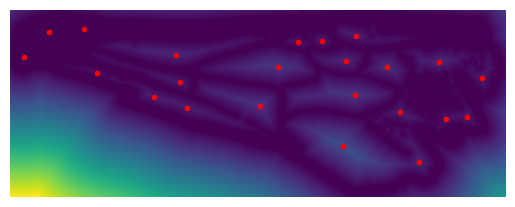

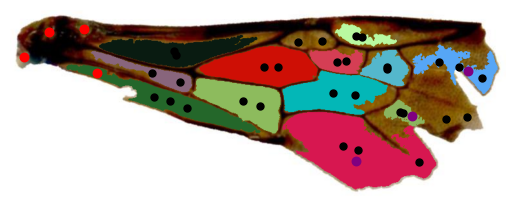

In [ ]:
# Start a timer 
start = time.time()

# Load color palette
sns_colors = sns.color_palette("hls", 8)

# Create output directories
output_subdir = output_dir + "Wings/"
os.makedirs(output_subdir, exist_ok=True)

# Find all jpg files
jpg_files = []
for root, _, files in os.walk(input_dir):
    for file in files:
        if file.endswith(".JPG") or file.endswith(".jpg"):
            jpg_files.append(os.path.join(root, file))

# Global warnings counter
total_warnings = 0

# Create or open a CSV file and write the header if it doesn't exist
output_file_path = os.path.join(output_dir, "WingAreas.csv")
header_written = os.path.exists(output_file_path)

with open(output_file_path, mode="a", newline="") as file:
    writer = csv.DictWriter(file, fieldnames=[
        "Filename", "VisibleWingAreaInPixels", "WingHeightInPixels", "Cell", "CellAreaInPixels", "CellPerimeterInPixels"
    ])
    if not header_written:
        writer.writeheader()

    # Process every jpg file
    total_files = len(jpg_files)
    digits = len(str(total_files))
    for idx, jpg_file_path in enumerate(jpg_files, 1):
        # Define file variables
        jpg_basename = os.path.basename(jpg_file_path)
        output_file = output_subdir + jpg_basename
        relative_jpg_path = jpg_file_path.removeprefix(input_dir)
        # Skip if the file exists
        if os.path.exists(output_file):
            print(f"Output already exists. Skipping File {idx:0{digits}}/{total_files}:\t{relative_jpg_path}")
            continue

        print(f"Processing File {idx:0{digits}}/{total_files}:\t{relative_jpg_path}")

        # Load the wing image
        image = cv2.imread(jpg_file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        """
        # Get the original dimensions of the image
        original_height, original_width = image.shape[:2]
        
        # Calculate the new dimensions
        new_width = original_width * 2
        new_height = original_height * 2
        
        # Resize the image
        image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_LINEAR)
        """
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

        # Find the wing cells
        segment_masks, fwl_mask, sorted_centroids, wing_stats = segmentation(gray, image)
        wing_area, wing_height = wing_stats

        # Save cell information in a dictionary
        wing_segments = {
            "MC": {"color": sns_colors[0], "mask": None, "wing_area": wing_area, "wing_height": wing_height, "cell_area": None, "cell_perimeter": None},
            "1sMC": {"color": sns_colors[1], "mask": None, "wing_area": wing_area, "wing_height": wing_height, "cell_area": None, "cell_perimeter": None},
            "2sMC": {"color": sns_colors[2], "mask": None, "wing_area": wing_area, "wing_height": wing_height, "cell_area": None, "cell_perimeter": None},
            "3sMC": {"color": sns_colors[3], "mask": None, "wing_area": wing_area, "wing_height": wing_height, "cell_area": None, "cell_perimeter": None},
            "2MdC": {"color": sns_colors[4], "mask": None, "wing_area": wing_area, "wing_height": wing_height, "cell_area": None, "cell_perimeter": None},
            "FWL": {"color": sns_colors[5], "mask": fwl_mask, "wing_area": wing_area, "wing_height": wing_height, "cell_area": None, "cell_perimeter": None}
        }

        # Clean duplicate masks
        cleaned_segment_masks = remove_duplicate_masks(segment_masks)

        # Find the cells neighboring the Forewing lobe
        neighbors = find_neighbor_masks(fwl_mask, cleaned_segment_masks)

        # The neighbor furthest to the top is the Marginal cell
        top_mask = find_top_mask(neighbors)
        wing_segments["MC"]["mask"] = top_mask
        # Remove the cell as possible option
        neighbors = [mask for mask in neighbors if not np.array_equal(mask, top_mask)]
        cleaned_segment_masks = [mask for mask in cleaned_segment_masks if not np.array_equal(mask, top_mask)]

        # The neighbor cell furthest to the top is the 3rd submarginal cell
        top_mask = find_top_mask(neighbors)
        wing_segments["3sMC"]["mask"] = top_mask
        # Remove the cell as possible option
        neighbors = [mask for mask in neighbors if not np.array_equal(mask, top_mask)]
        cleaned_segment_masks = [mask for mask in cleaned_segment_masks if not np.array_equal(mask, top_mask)]

        # Remove the cell, the next cell furthest to the top is the 2nd medial cell
        right_mask = find_rightmost_mask(neighbors)
        wing_segments["2MdC"]["mask"] = right_mask
        # Remove the cell as possible option
        cleaned_segment_masks = [mask for mask in cleaned_segment_masks if not np.array_equal(mask, right_mask)]

        # Find the cells neighboring the Marginal cell
        neighbors = find_neighbor_masks(wing_segments["MC"]["mask"], cleaned_segment_masks)

        # The neighbor cell furthest to the top is the 1st submarginal cell
        top_mask = find_top_mask(neighbors)
        wing_segments["1sMC"]["mask"] = top_mask
        # Remove the cell as possible option
        neighbors = [mask for mask in neighbors if not np.array_equal(mask, top_mask)]
        cleaned_segment_masks = [mask for mask in cleaned_segment_masks if not np.array_equal(mask, top_mask)]

        # The neighbor cell furthest to the top is the 2nd submarginal cell
        top_mask = find_top_mask(neighbors)
        wing_segments["2sMC"]["mask"] = top_mask
        # Remove the cell as possible option
        neighbors = [mask for mask in neighbors if not np.array_equal(mask, top_mask)]
        cleaned_segment_masks = [mask for mask in cleaned_segment_masks if not np.array_equal(mask, top_mask)]

        # Calculate the cell area in pixels and save the mask image 
        wing_segments = calculate_cell_features(image, wing_segments, output_file)

        # Loop through each wing cell and write to file
        for segment_name, segment_data in wing_segments.items():
            writer.writerow({
                "Filename": jpg_basename, 
                "VisibleWingAreaInPixels": segment_data["wing_area"], 
                "WingHeightInPixels": segment_data["wing_height"], 
                "Cell": segment_name, 
                "CellAreaInPixels": segment_data["cell_area"], 
                "CellPerimeterInPixels": segment_data["cell_perimeter"]
            })

# Print Total Warnings
print(f"\nTotal Warnings: {total_warnings}")

# End the timer 
end = time.time()
duration = end - start

# Convert to hours, minutes, and seconds
hours = int(duration // 3600)
minutes = int((duration % 3600) // 60)
seconds = int(duration % 60)

# Print the runtime in hh:mm:ss format
print(f"Script Runtime (hh:mm:ss): {hours:02}:{minutes:02}:{seconds:02}")